# 1. Explore the models

Welcome to the guide for the ANDI 2 challenge datasets. In this notebook we will explore the new diffusion models considered for the challenge. As opposed to the diffusion models of the previous challenge (check the [paper](https://www.nature.com/articles/s41467-021-26320-w) and the [previous tutorial](challenge_one_datasets.ipynb) ), this time we focus on *phenomenological* models. That is, models in which diffusion properties arise from the interaction of the moving particle with the environment, or due to its inherent properties. Moreover, we will focus in models in which diffusive changes happened randomly, because of different reasons. Nonetheless, we are still in the ANDI Challenge, so *anomalous* is still here! All particles will diffuse following fractional Brownian motion, with different anomalous exponents $\alpha$. We have developed 5 types of diffusion, with which we want to cover most of the phenomena one encounters in real, physical, scenarios. Before reviewing them, let us set some initial conditions which will be considered in all models. These parameters will be similar to the ones considered in the datasets generated for the challenge.

#### Experimental diffusion conditions

##### Field of view `fov` and system size `L`
We consider the trajectories to be recorded by a device with field of view $128 \times 128 px^2$, with a pixel size of 100 nm. In order to avoid boundary effects, we will usually simulate the diffusion in a box of size $L =1.5 \ \times$ `fov`.

##### Frame rate
In the same spirit, we consider a tracking device working at a frame rate of $= 0.1 Hz$. This means that each time step of the particle $\Delta t = 100 \ ms  = 0.1 \ s$. 

##### Diffusion coefficient `D`
Typically, microparticles in biological environments diffuse with coefficient of the order of $0.01 \ \mu m^2/s$. In order to get a meaningful value to input the diffusion model generators, we need to consider the following:

- As a working definition of $D$, valid also for anomalous diffusion, we consider it as proporcional to the variance of the displacements along one dimension at the shortest time lag, i.e. $\sigma_{\Delta x}^2= 2  D \Delta t$.
    
- Given the values of pixel size and frame rate, in adimensional units $D$ is given by: $D= 0.01 \ \frac{\mu m^2}{s} \ \frac{0.1 s/ \Delta t }{  0.01 \mu m^2/px^2} = 0.1 \ px^2/\Delta t$.

##### Localization precision `sigma_x`
To replicate experimental conditions, we usually consider the presence of uncorrelated noise in the tracking of the particles. This is taken into account by considering a localization precision of $\sigma_{x} = 12 \ nm = \frac{12 \ nm} {100 \ nm/px}  = 0.12 \ px$.

# Creating trajectories from phenomenolgical models
All models are gathered in a single class, easily accessed using the cell below. We will also import some usefull libraries to showcase some of the properties of the models. After that,  we are ready to explore the various diffusion models available.

In [ ]:
from andi_datasets.models_phenom import models_phenom

# auxiliaries
import numpy as np
import matplotlib.pyplot as plt

### Model 1 - Single state diffusion
This is the most *boring* model of all... It simulates a particle with a single diffusive state, with an associated $D$ and $\alpha$. This kind of trajectories can also be generated with the class `models_theory`, check [its associated tutorial](challenge_one_datasets.ipynb) to know more. 

All models have similar inputs, with some changing to accomodate the particularities of each model. In general, we input the number of trajectories to be generated `N`, the number of time steps `T`, and then length of the box acting as environment `L`. Let's us define these and keep them for the rest of the notebook. We will also define here the diffusion coefficient.

In [ ]:
# number of time steps per trajectory (frames)
T = 500
# number of trajectories
N = 10000
# Length of box (pixels)
L = 1.5*128
# diffusion coefficient (pixels^2 / frame)
D = [0.1, 0.1]

Let's us generate some trajectories with anomalous exponent `alpha = 0.5`. Remember that all trajectories follow FBM! The output of all the functions is the same: a tuple whose first elements are the trajectories and second are its labels. Let's focus on the first now:

In [ ]:
trajs_model1, labels = models_phenom().single_state(N = N, 
                                                L = L,
                                                T = T,
                                                Ds = D,
                                                alphas = 0.5
                                                )

The trajectories will have always the same shape: time, number of trajectories and number of dimensions (two for this challenge).

In [ ]:
trajs_model1.shape

(500, 50, 2)

Let's take a look at some of the trajectories with a built-in functions from the library:

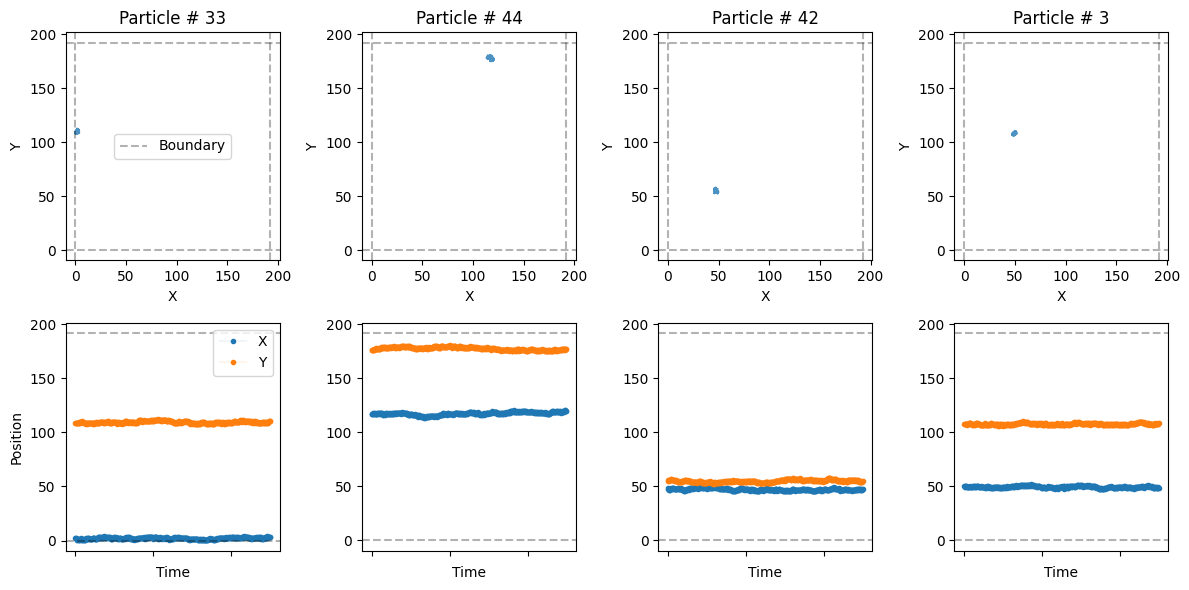

In [ ]:
from andi_datasets.utils_trajectories import plot_trajs

plot_trajs(trajs_model1, L, N, num_to_plot = 4)

### Model 2 - Multiple state diffusion
Now we consider the motion of a particle that changes between different diffusive state. We are free to choose the number of states. The probability of jumping from one state to another is given by the transition matrix $M$. Let's consider a two-state diffusion process. It's transition matrix is

$M = \begin{pmatrix} P_{11} & P_{12} \\ P_{21} & P_{22} \end{pmatrix} = \begin{pmatrix} 0.98 & 0.02 \\   0.02 & 0.98 \end{pmatrix},$

where $P_{ij}$ is the probability of changing from state $i$ to state $j$ at every time step. Each diffusive state can have its own diffusion coefficient and anomalous exponent. For instance, we consider a fast state with $D_f = 10 D$ and $\alpha_f = 1.2$ and a slow state with $D_s = 0.1 D$ and $\alpha_s = 0.7$. Given this, let's create some trajectories! 

In [ ]:
trajs_model2, labels_model2 = models_phenom().multi_state(N = N, 
                                                          L = L,
                                                          T = T,
                                                          alphas = [1.2, 0.7],
                                                          Ds = [10*D, 0.1*D],
                                                          M = [[0.98, 0.02], [0.02, 0.98]]
                                                            )

See that now we have define the labels of the trajectories. This contain very important information: the value of $\alpha$ and $D$ at each time step. For instance, let's check the values of the labels for the first particle:

In [ ]:
print(r'alphas:', np.unique(labels_model2[:, 0, 0]), 'D:', np.unique(labels_model2[:, 0, 1]) )

alphas: [0.7 1.2] D: [0.01 1.  ]


Now, let's plot them to see how they change over time. You can see them in third row of the next plot:

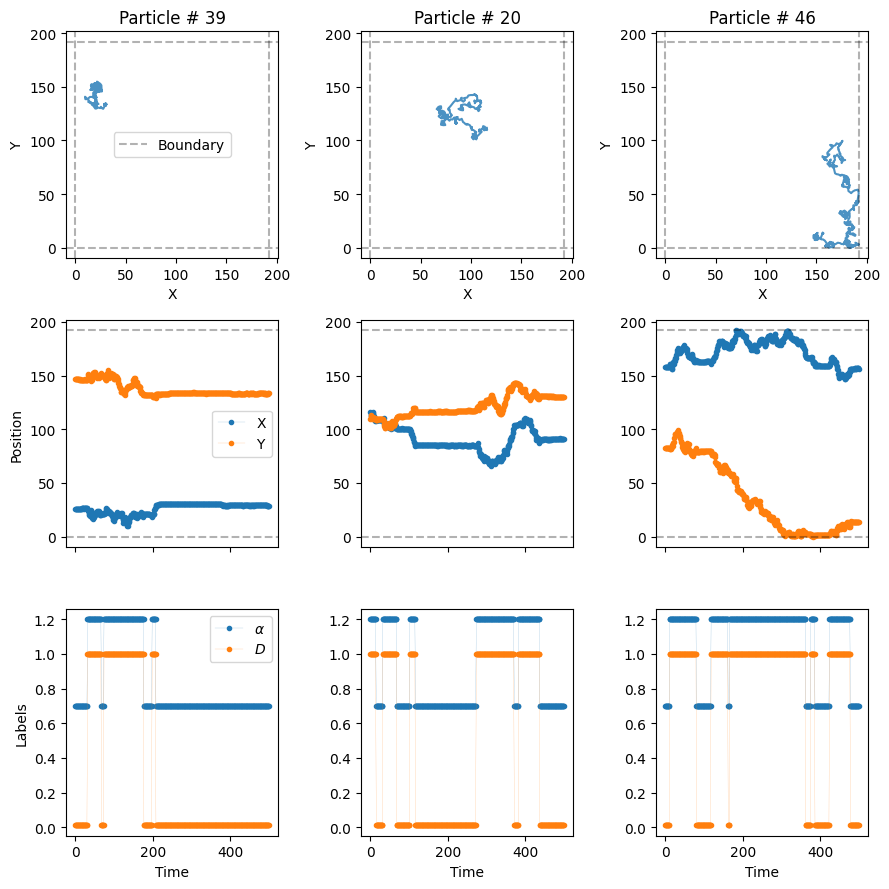

In [ ]:
plot_trajs(trajs_model2, L, N, labels = labels_model2, plot_labels = True)

As you can see, $\alpha$ and $D$ change over time randomly, following the transition matrix $M$. If you prefer to work with changepoints and physical properties in the different systems, you can use the following function for it:

In [ ]:
from andi_datasets.utils_challenge import label_continuous_to_list

changepoints, alphas, Ds, state_num = label_continuous_to_list(labels_model2[:, 0, :])

print('changepoints:', changepoints,
      '\nalphas:', alphas,
      '\nDs:', Ds)

changepoints: [ 14  73  88 106 155 170 290 351 394 407 445 500] 
alphas: [0.7 1.2 0.7 1.2 0.7 1.2 0.7 1.2 0.7 1.2 0.7 1.2] 
Ds: [0.01 1.   0.01 1.   0.01 1.   0.01 1.   0.01 1.   0.01 1.  ]


The previous gives $C$ changepoints, which creates $C+1$ segments, and hence $C+1$ $\alpha$s and $D$s.

### Model 3 - Dimerization
The third model considers a set of trajectories moving all in the same environment. They have all the same properties: diffusion coefficient, anomalous exponent and radius. If two particles get closer than a distance $2r$, they bind with probability $P_b$ creating a dimer. Similarly, two dimerized particles may unbind with probability $P_u$. The latter defines two diffusive states. Just as before, we can define the diffusion coefficients and exponents of both states. Here is an example of such process:

In [ ]:
trajs_model3, labels_model3 = models_phenom().dimerization(N = N, 
                                                           L = L,
                                                           T = T,
                                                           alphas = [1.2, 0.7],
                                                           Ds = [10*D, 0.1*D],
                                                           r = 1, # radius of the particles
                                                           Pb = 1, # binding probability
                                                           Pu = 0 # unbinding probability
                                                           )

Now, let's plot them to see how they change over time. You can see them in third row of the next plot:

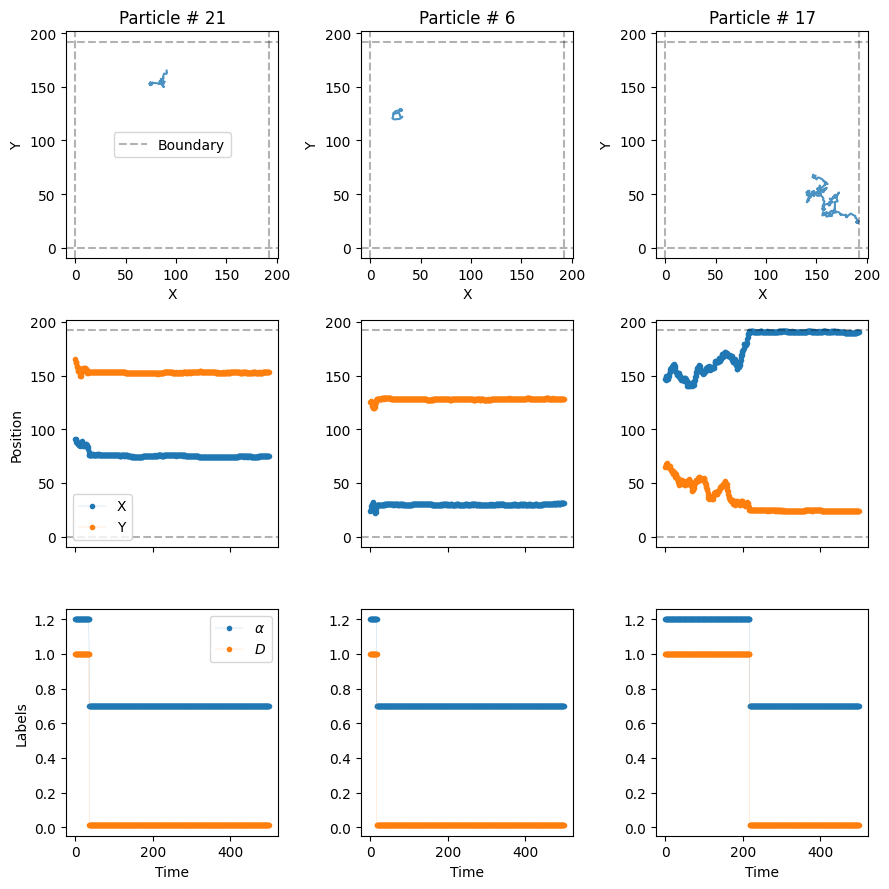

In [ ]:
plot_trajs(trajs_model3, L, N, labels = labels_model3, plot_labels = True)

As you can see, particle 2 and 3 met and change their diffusive state!

### Model 4 - Immobile traps
The forth model consider the presence of immobile traps of radius $r$ which completely immobilize the particles. Similar to the dimerization model, the particles have a probability $P_b$ of getting trapped if closer to the trap than a distance $r$ and a probability $P_u$ of escaping from it. The generator of this trajectories allows us (optional) to set the position of the traps. Let's throw them randomly over the box:

In [ ]:
number_traps = 100
traps_positions = np.random.rand(number_traps, 2)*L 

Now, let's put some particles in the system, with usual diffusion coefficient $D$ and an $\alpha = 1.6$.

In [ ]:
trajs_model4, labels_model4 = models_phenom().immobile_traps(N = N,
                                                             T = T,                
                                                             L = L,
                                                             r = 1, # radius of the traps
                                                             Pu = 0.01, # Unbinding probability
                                                             Pb = 1, # Binding probability
                                                             Ds = D, # Diffusion coefficients of moving state
                                                             alphas = 1.6, # Anomalous exponents of moving state
                                                             Nt = number_traps, # number of traps
                                                             traps_pos = traps_positions
                                                             )

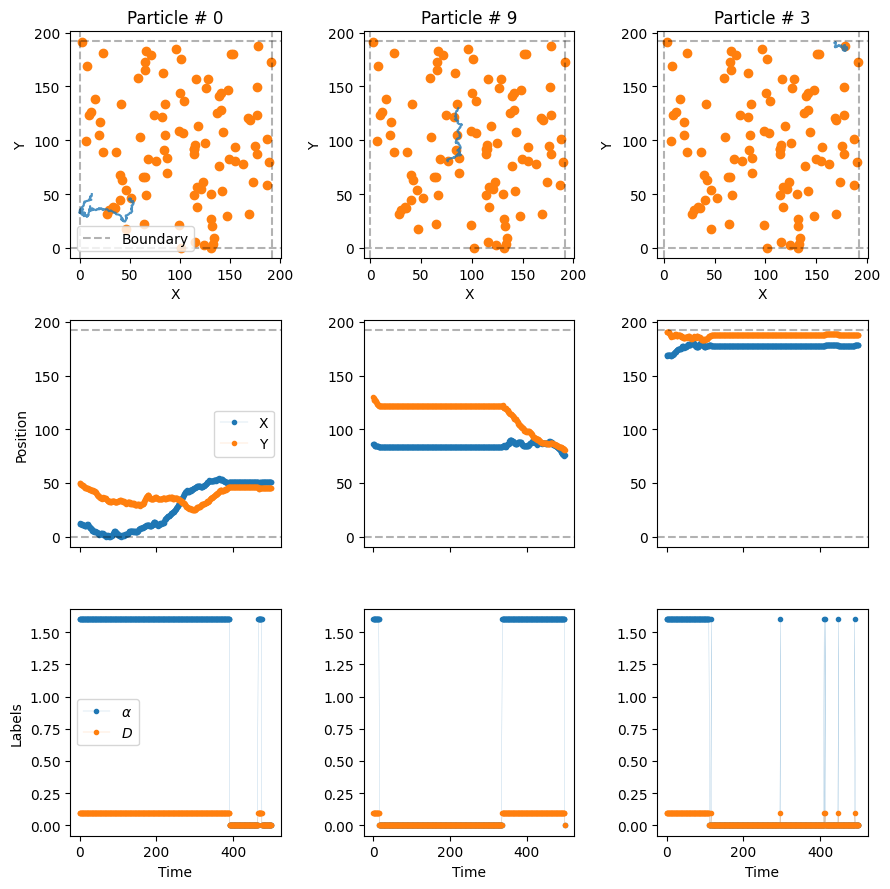

In [ ]:
plot_trajs(trajs_model4, L, N, 
           labels = labels_model4, plot_labels = True,
           traps_positions = traps_positions)


As you can see, in this case the particles superdiffuse until the hit a trap, moment in which they get immobilized!

### Model 5 - Confinement
Last but not least, we have one of the most relevant models of the challenge: the presence of compartments, whose boundaries can prevent particles to exit them. Note that we consider here the case of *osmotic* boundaries, which means that the particles will always enter the compartment. Once inside, the boundaries have a certain transmittance `trans`, i.e. the probability of the particle exiting the compartment. Just as the case of immobile traps, we can define (optionally) a priori the compartments' distribution. Note that we always consider here circular compartment of given radius `r`. You can use the following built-in function to distribute cercles over the environment, without overlap. If the algorithm does manage to place them all, a warning is printed, and only the circles states are placed.

In [ ]:
number_compartments = 50;
radius_compartments = 10
compartments_center = models_phenom._distribute_circular_compartments(Nc = number_compartments, 
                                                                      r = radius_compartments,
                                                                      L = L # size of the environment
                                                                      ) 

We can check the distribution of the compartments like below. As you can see, the environment is quite dense!

[0.0, 192.0, 0.0, 192.0]

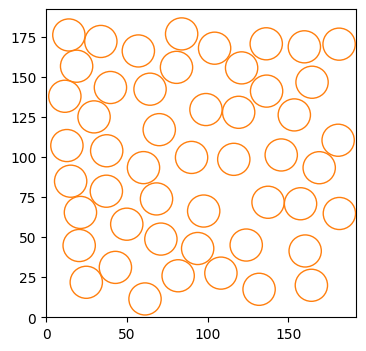

In [ ]:
fig, ax = plt.subplots(figsize = (4,4))
for c in compartments_center:
    circle = plt.Circle((c[0], c[1]), radius_compartments, facecolor = 'None', edgecolor = 'C1', zorder = 10)
    ax.add_patch(circle) 
plt.setp(ax, xlim = (0, L), ylim = (0, L))  

Now, let's introduce some diffusive particles in this environment. We will consider a quite extreme case, to nicely show the effect of the compartments. Outside the comparments, the particles will move very, very fast, at $D_f = 1500D$. Replicating what we see in many biological scenarios, inside the compartments the particles will move much slower, $D_s = 50 D$. Let's keep the both diffusive with same anomalous exponent, $\alpha = 1$.

**Comment on default values:** the default values for `alpha` are always 1 for all methods. Hence, if no exponents are given, all diffusive states are normally diffusing. Most of the variables of the functions presented here have default values, with similar values as the ones used in this notebook. If you want to know more, you can check their [source code](../lib_nbs/models_phenom.ipynb).

For the boundaries of the compartments, let's consider a transmittance `trans` = 0.2:

In [ ]:
trajs_model5, labels_model5 = models_phenom().confinement(N = N,
                                                          L = L,
                                                          Ds = [1500*D, 50*D],
                                                          comp_center = compartments_center,
                                                          r = radius_compartments,
                                                          trans = 0.2 # boundary transmittance
                                                           )

Let's see the resulting trajectories, superimposed to the cercles we create just before.

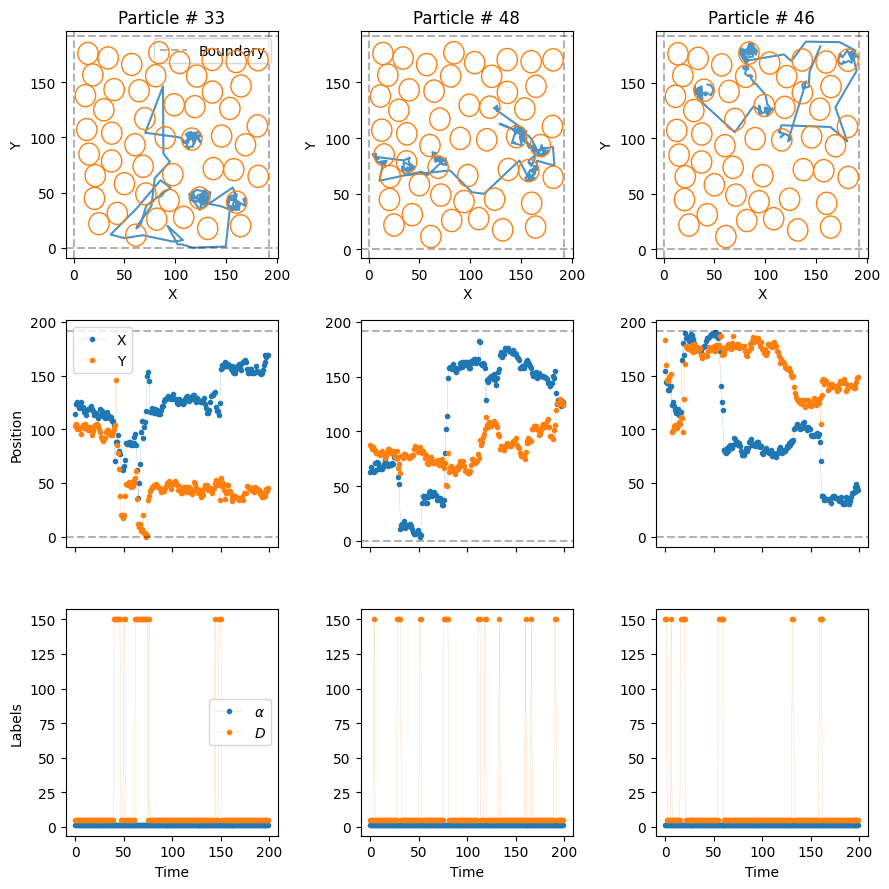

In [ ]:
plot_trajs(trajs_model5, L, N, 
           comp_center = compartments_center,
           r_cercle = radius_compartments,
           plot_labels = True, labels = labels_model5
           )

With these extreme diffusion coefficient, he make it such that the particles move very fast from one compartment to the other. Once inside, the low transmittance of the boundaries make it such that they stay quite some time inside!

#  Creating datasets with multiple models

The library allows to generate simultaneously trajectories from all the previous models, and gather them in a single dataset. To do so, we have created the the class `datasets_phenom`. Let's import it and see some of its properties:

In [ ]:
from andi_datasets.datasets_phenom import datasets_phenom

One of the first things we can check is the models that we can access with this class. Spoiler: they are the same we just reviewed above!

In [ ]:
datasets_phenom().avail_models_name

['single_state',
 'multi_state',
 'immobile_traps',
 'dimerization',
 'confinement']

As we have seen previously, each model has its own parameters. As we commented, most of them have some meaningful default values, so we can skip them when generating trajectories. Nonetheless, if you want to know the parameters for a given model, you can use:

In [ ]:
model = 'confinement'
datasets_phenom()._get_inputs_models(model)

['N',
 'T',
 'L',
 'Ds',
 'alphas',
 'gamma_d',
 'epsilon_a',
 'r',
 'comp_center',
 'Nc',
 'trans',
 'deltaT']

Of course, you can also check the [Documentation](https://andichallenge.github.io/andi_datasets/) and inspect all the details about the models.

In order to generate trajectories, we first need to set: 1) the models we want to generate trajectories from; 2) the properties of each of the models. For that, we need to create a *dictionary* that stores all the needed information. For each model, a dictionary is needed. Hence, for multiple models, we will need to input a list of dictionaries. For example, let's create a dataset with trajectories from the dimerization (model 3) and confinement (model 5) models. We will make use of the default values of the previous models, and only input the binding/unbinding probability for the former and the transmittance for the latter.

In [ ]:
dict_model3 = {'model': 'dimerization', 
               'L': L,
               'Pu': 0.1, 'Pb': 1}

dict_model5 = {'model': 'confinement', 
               'L': L,
               'trans': 0.2}

dict_all = [dict_model3, dict_model5]

trajs, labels = datasets_phenom().create_dataset(N_model = N, # number of trajectories per model
                                                 T = T,
                                                 dics = dict_all,
                                            
                                                )

The trajectories arising from the previous function are ordered following the order of the input list of dictionaries. We requested `N_model = N = 50` trajectories per model, hence the dataset will have a total of 100 trajectories. The first 50 will come from the dimerization model and the last 50 from the confinement model.

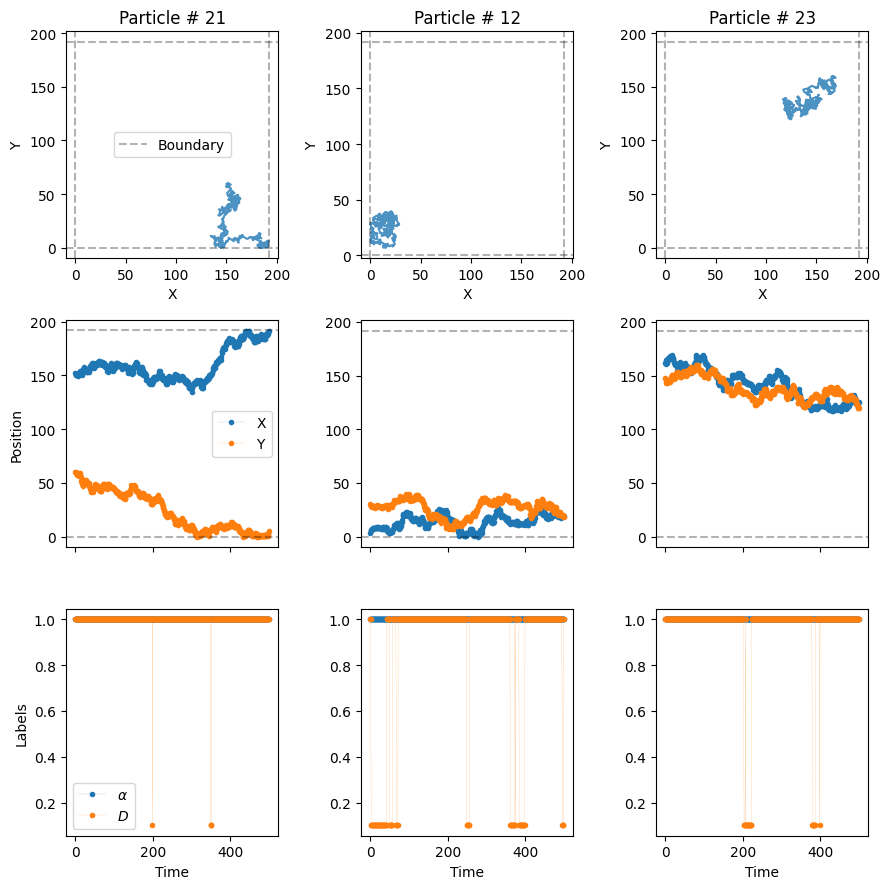

In [ ]:
from andi_datasets.utils_trajectories import plot_trajs

plot_trajs(trajs, L, N, 
           plot_labels = True, labels = labels
           )

### Saving and loading datasets

Just as with the `datasets_theory` class (check here the details), you can save and load datasets, so that you avoid creating trajectories every time you need them. The same function presented above has such options:

In [ ]:
trajs, labels = datasets_phenom().create_dataset(N_model = N, # number of trajectories per model
                                                 T = T,
                                                 dics = dict_all,
                                                 save = True, path = 'datasets_folder/'
                                                )

c:\users\gorka\github\andi_datasets\andi_datasets\datasets_phenom.py:268: UserWarning: The dataset you want to save already exists (file: dimerization_0.npy). Switching to Load mode.
  warnings.warn(wrn_str)
c:\users\gorka\github\andi_datasets\andi_datasets\datasets_phenom.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dic, ignore_index = True)


Saving creates two files per model:

   - a ``.csv`` file, containing the details of the dataset generated. This file stores the values of the parameters of the saved dataset. This file helps organizing all the saved datasets and is used later to know, given some parameters, from where to load the trajectories.
    
   - a ``.npy`` file, containing the trajectories and labels of the generated trajectories. Each file will have an integer number at end, which is used, together with the csv file, in order to know the properties of the dataset.
   
After saving, we can just load the dataset with the same function:

In [ ]:
from andi_datasets.datasets_phenom import datasets_phenom

In [ ]:
trajs, labels = datasets_phenom().create_dataset(N_model = N, # number of trajectories per model
                                                 T = T,
                                                 dics = dict_all,
                                                 load = True, path = 'datasets_folder/'
                                                )

ValueError: The dataset you want to load does not exist.